In [ ]:
import torch
torch.cuda.empty_cache()
torch.cuda.memory_summary(device=None, abbreviated=False)
from tsai.all import *
import sklearn.metrics as skm
import sys
from sklearn.model_selection import train_test_split
import numpy as np
import random
from IPython.display import clear_output


sys.path.append('../pre_processing_and_recover_network')
import data_preprocessing
my_setup()

In [2]:
def get_train_test_indexes_by_pivot(index_list, pivot):
    test_indexes = [i for i, idx in enumerate(index_list) if idx == pivot]
    train_indexes = [i for i in range(len(index_list)) if i not in test_indexes]
    return train_indexes, test_indexes

In [3]:
# prepare the data
swell_data = data_preprocessing.load_data(os.path.join("../pre_processing_and_recover_network/swell_dataset/","swell_dict.npy"))
swell_data = data_preprocessing.swell_prepare_for_10fold(swell_data)
swell_data[:, 1:4] -= 1
x = swell_data[:, 4:]

y_arousal = swell_data[:, 2]
y_arousal = y_arousal.reshape(y_arousal.shape[0],)

y_valence = swell_data[:, 3]
y_valence = y_valence.reshape(y_valence.shape[0],)

y_stress = swell_data[:, 1]
y_stress = y_stress.reshape(y_stress.shape[0],)

print(x.shape)
print(type(x))
print(y_stress.shape)
print(y_valence.shape)
print(y_arousal.shape)


# set X to 3-Dim array
x = np.array(x)
x = np.expand_dims(x, axis=1)
print(x.shape)
filename = 'X_memmap.npy'
X = np.memmap(filename, dtype='float32', mode='w+', shape=x.shape)
X[:] = x[:]
print(X.shape)
print(type(X))

filename = 'Y_arousal_memmap.npy'
Y_arousal = np.memmap(filename, dtype='float32', mode='w+', shape=y_arousal.shape)
Y_arousal[:] = y_arousal[:]

filename = 'Y_valence_memmap.npy'
Y_valence = np.memmap(filename, dtype='float32', mode='w+', shape=y_valence.shape)
Y_valence[:] = y_valence[:]

filename = 'Y_stress_memmap.npy'
Y_stress = np.memmap(filename, dtype='float32', mode='w+', shape=y_stress.shape)
Y_stress[:] = y_stress[:]
print(Y_stress.shape)
print(type(Y_stress))


(14595, 2560)
<class 'numpy.ndarray'>
(14595,)
(14595,)
(14595,)
(14595, 1, 2560)
(14595, 1, 2560)
<class 'numpy.memmap'>
(14595,)
<class 'numpy.memmap'>


In [ ]:
pp= set(swell_data[:,0])
pp=sorted(pp)

**Prepare dataset loaders and model**

In [ ]:
c_in=1
c_out_stress=3
seq_len=2560
bs=128

for p in pp:
    p=int(p)
    if(p<40):
        print("PP ",p)
        tfms  = [None, [Categorize()]]
        splits=get_train_test_indexes_by_pivot(swell_data[:,0],p) 
        dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)
        dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
        model_stress = InceptionTime(c_in=c_in, c_out=c_out_stress, seq_len=seq_len)
        learn_stress =  ts_learner(dls_stress, model_stress, metrics=accuracy, train_metrics=True)
        lr = learn_stress.lr_find()
        lr = lr.valley
        print("lr is ",lr)
        record=[]
        for i in range(100):
            learn_stress.fit_one_cycle(1,lr_max=lr)
            record.append(learn_stress.final_record.items)
        np.save("./recording_leave_one/PP_"+str(p),record)
        learn_stress.save_all(path='./learners', dls_fname='dls_stress_'+str(p), model_fname='model_stress_'+str(p), learner_fname='learner_stress_'+str(p))
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)
     



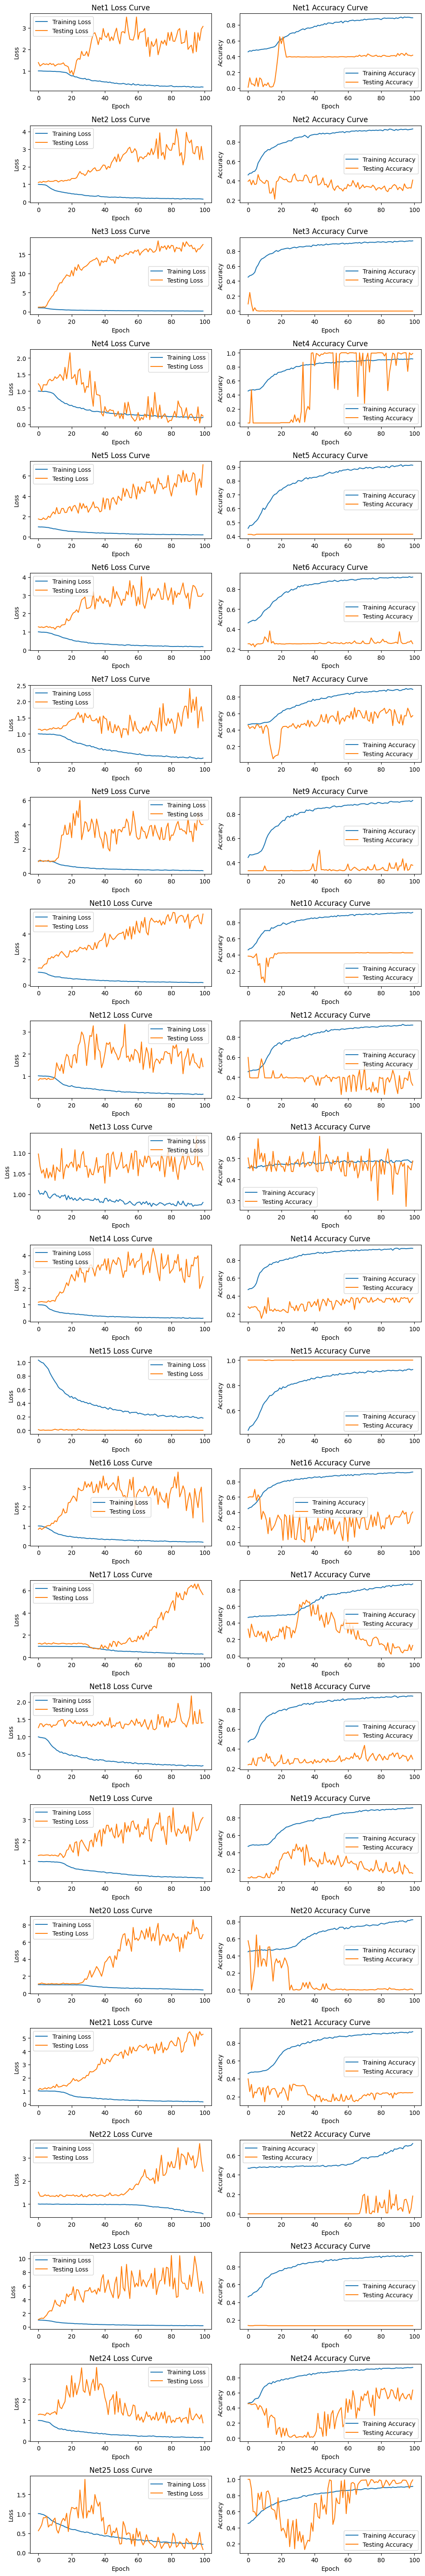

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_train_final=[]
loss_test_final=[]
acc_train_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(23, 2, figsize=(10, 60))

for net in range(1, 24):
    record=np.load("./recording_leave_one/PP_"+str(int(pp[net-1]))+".npy") 
    train_loss = record[:,0]
    loss_train_final.append(train_loss[99])
    test_loss = record[:,2]
    loss_test_final.append(test_loss[99])
    train_acc = record[:,1]
    acc_train_final.append(train_acc[99])
    test_acc = record[:,3]
    acc_test_final.append(test_acc[99])
    # Plot the training and testing loss curves for this network
    axs[net-1, 0].plot(train_loss, label="Training Loss")
    axs[net-1, 0].plot(test_loss, label="Testing Loss")
    axs[net-1, 0].set_title(f"Net{int(pp[net-1])} Loss Curve")
    axs[net-1, 0].set_xlabel("Epoch")
    axs[net-1, 0].set_ylabel("Loss")
    axs[net-1, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[net-1, 1].plot(train_acc, label="Training Accuracy")
    axs[net-1, 1].plot(test_acc, label="Testing Accuracy")
    axs[net-1, 1].set_title(f"Net{int(pp[net-1])} Accuracy Curve")
    axs[net-1, 1].set_xlabel("Epoch")
    axs[net-1, 1].set_ylabel("Accuracy")
    axs[net-1, 1].legend()

plt.tight_layout()
plt.show()


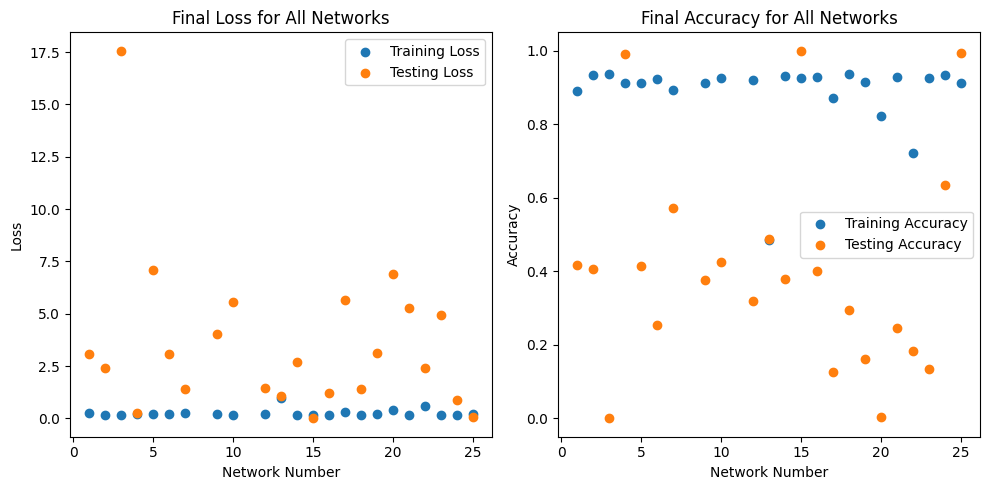

In [33]:


train_loss = loss_train_final
test_loss = loss_test_final
train_acc = acc_train_final
test_acc = acc_test_final
import matplotlib.pyplot as plt


    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the final training and testing loss for all networks
axs[0].scatter(pp, train_loss, label="Training Loss")
axs[0].scatter(pp, test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(pp, train_acc, label="Training Accuracy")
axs[1].scatter(pp, test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()


In [35]:
learn_rec = load_all(path='./learners', dls_fname='dls_stress_1', model_fname='model_stress_1', learner_fname='learner_stress_1')
print(model_stress)

InceptionTime(
  (inceptionblock): InceptionBlock(
    (inception): ModuleList(
      (0): InceptionModule(
        (convs): ModuleList(
          (0): Conv1d(1, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
          (1): Conv1d(1, 32, kernel_size=(19,), stride=(1,), padding=(9,), bias=False)
          (2): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=(4,), bias=False)
        )
        (maxconvpool): Sequential(
          (0): MaxPool1d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
          (1): Conv1d(1, 32, kernel_size=(1,), stride=(1,), bias=False)
        )
        (concat): Concat(dim=1)
        (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act): ReLU()
      )
      (1): InceptionModule(
        (bottleneck): Conv1d(128, 32, kernel_size=(1,), stride=(1,), bias=False)
        (convs): ModuleList(
          (0): Conv1d(32, 32, kernel_size=(39,), stride=(1,), padding=(19,), bias=False)
 

**EX1**

In [ ]:
c_in=1
c_out_stress=3
seq_len=2560
bs=128

for p in pp:
    p=int(p)
    if(1==1):
        print("PP ",p)
        tfms  = [None, [Categorize()]]
        splits=get_train_test_indexes_by_pivot(swell_data[:,0],p) 
        dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)
        dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
        model_stress = InceptionTime(c_in=c_in, c_out=c_out_stress, seq_len=seq_len)
        learn_stress =  ts_learner(dls_stress, model_stress, metrics=accuracy, train_metrics=True)
        record=[]
        for i in range(500):
            learn_stress.fit_one_cycle(1,lr_max=1e-3)
            record.append(learn_stress.final_record.items)
        np.save("./EX1/PP_"+str(p),record)
        learn_stress.save_all(path='./learners_EX1', dls_fname='dls_stress_'+str(p), model_fname='model_stress_'+str(p), learner_fname='learner_stress_'+str(p))
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)

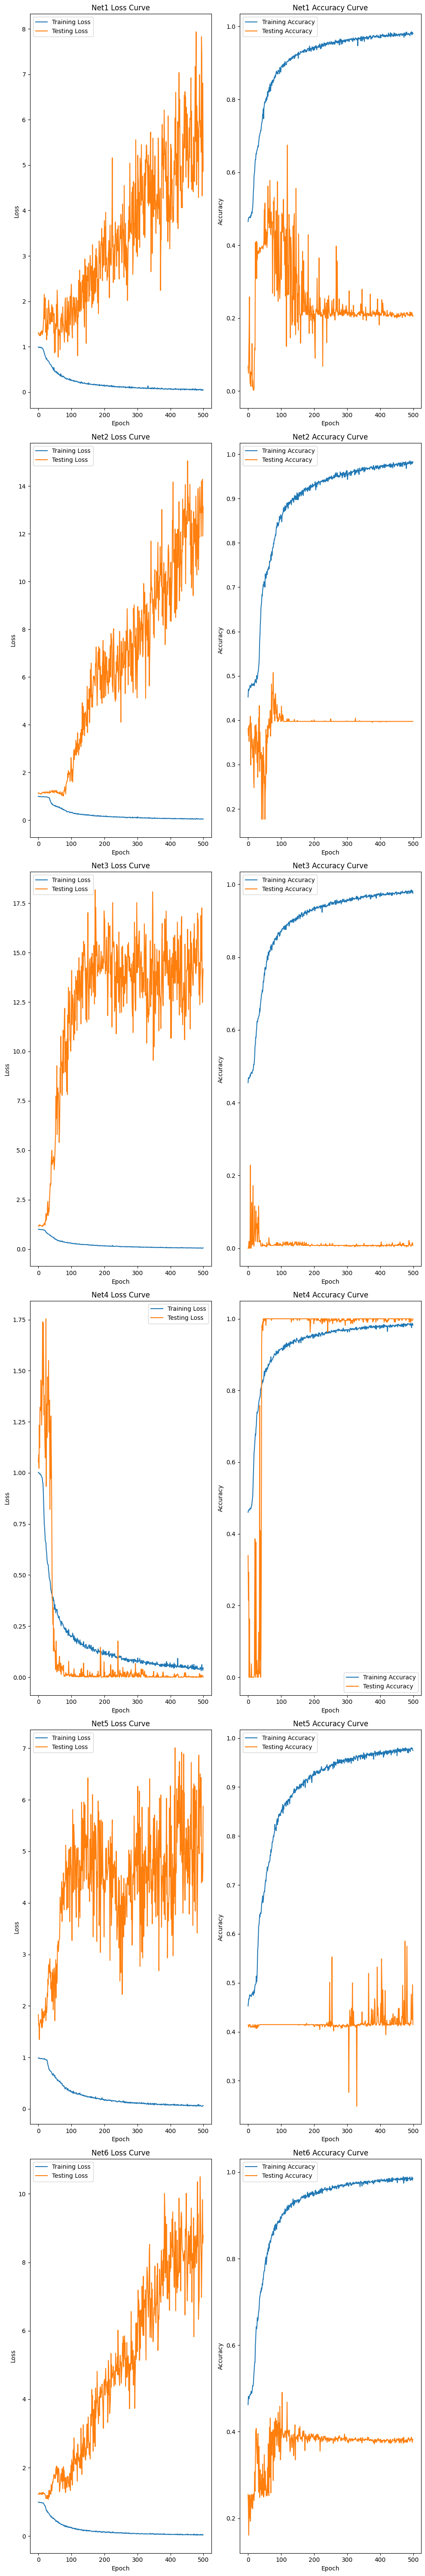

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_train_final=[]
loss_test_final=[]
acc_train_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(6, 2, figsize=(10, 60))

for net in range(1, 7):
    record=np.load("./EX1/PP_"+str(int(pp[net-1]))+".npy") 
    train_loss = record[:,0]
    loss_train_final.append(train_loss[499])
    test_loss = record[:,2]
    loss_test_final.append(test_loss[499])
    train_acc = record[:,1]
    acc_train_final.append(train_acc[499])
    test_acc = record[:,3]
    acc_test_final.append(test_acc[499])
    # Plot the training and testing loss curves for this network
    axs[net-1, 0].plot(train_loss, label="Training Loss")
    axs[net-1, 0].plot(test_loss, label="Testing Loss")
    axs[net-1, 0].set_title(f"Net{int(pp[net-1])} Loss Curve")
    axs[net-1, 0].set_xlabel("Epoch")
    axs[net-1, 0].set_ylabel("Loss")
    axs[net-1, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[net-1, 1].plot(train_acc, label="Training Accuracy")
    axs[net-1, 1].plot(test_acc, label="Testing Accuracy")
    axs[net-1, 1].set_title(f"Net{int(pp[net-1])} Accuracy Curve")
    axs[net-1, 1].set_xlabel("Epoch")
    axs[net-1, 1].set_ylabel("Accuracy")
    axs[net-1, 1].legend()

plt.tight_layout()
plt.show()

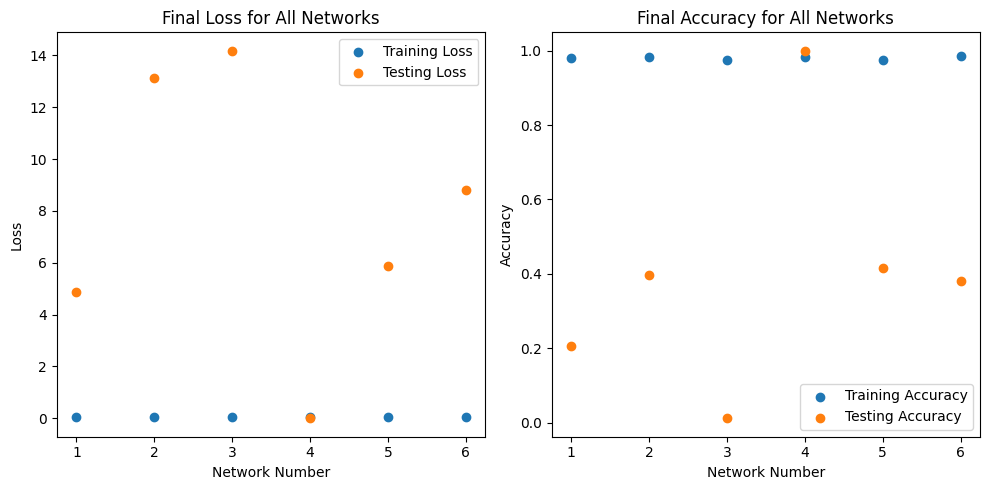

In [14]:
train_loss = loss_train_final
test_loss = loss_test_final
train_acc = acc_train_final
test_acc = acc_test_final
import matplotlib.pyplot as plt


    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the final training and testing loss for all networks
axs[0].scatter(pp[:6], train_loss, label="Training Loss")
axs[0].scatter(pp[:6], test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(pp[:6], train_acc, label="Training Accuracy")
axs[1].scatter(pp[:6], test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

**EX2**

In [ ]:
c_in=1
c_out_stress=3
seq_len=2560
bs=128
more={"ks":20}

for p in pp:
    p=int(p)
    if((p<7)and(p>5)):
        print("PP ",p)
        tfms  = [None, [Categorize()]]
        splits=get_train_test_indexes_by_pivot(swell_data[:,0],p) 
        dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)
        dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
        model_stress = InceptionTime(c_in=c_in, c_out=c_out_stress, seq_len=seq_len, **more)
        learn_stress =  ts_learner(dls_stress, model_stress, metrics=accuracy, train_metrics=True)
        record=[]
        for i in range(500):
            learn_stress.fit_one_cycle(1,lr_max=1e-3)
            record.append(learn_stress.final_record.items)
        np.save("./EX2/PP_"+str(p),record)
        learn_stress.save_all(path='./learners_EX2', dls_fname='dls_stress_'+str(p), model_fname='model_stress_'+str(p), learner_fname='learner_stress_'+str(p))
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)

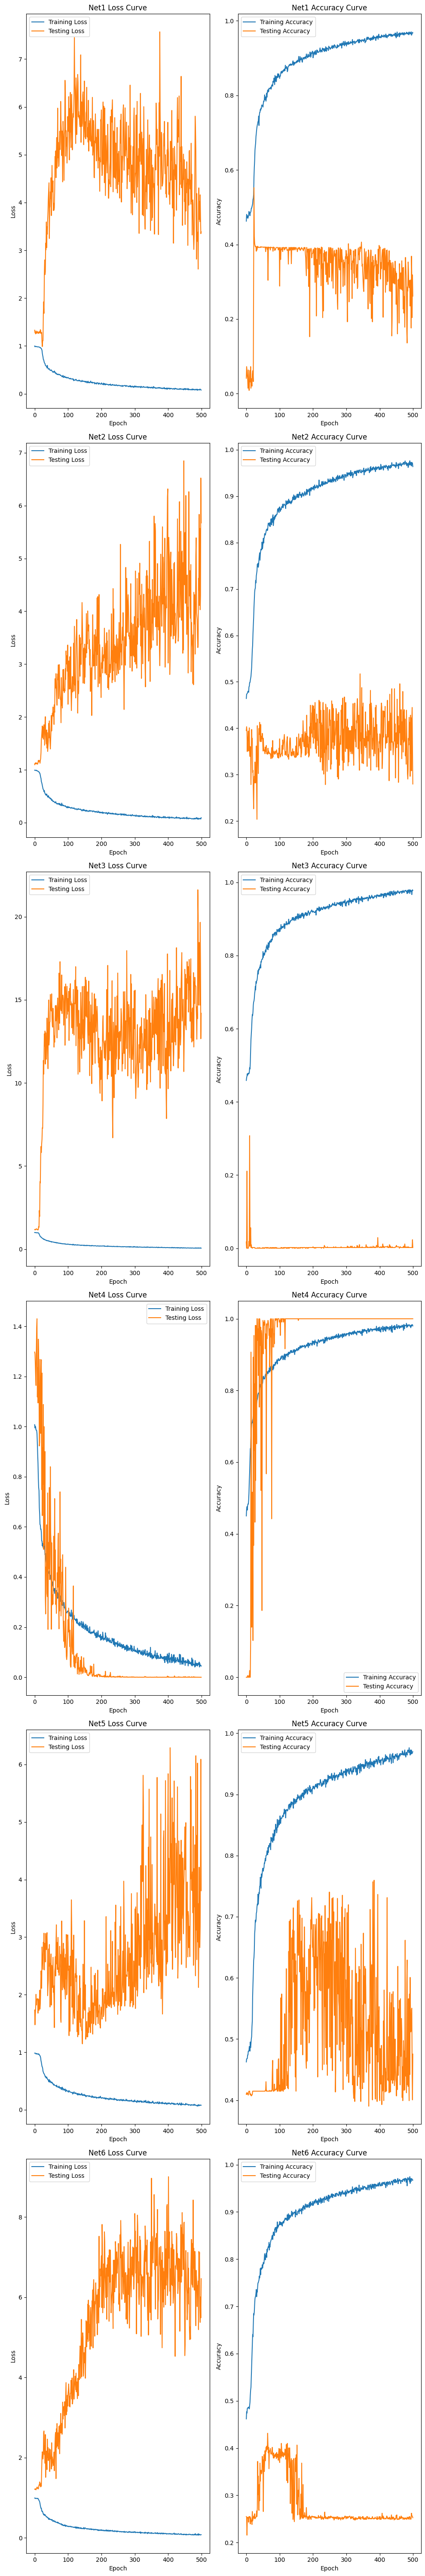

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_train_final=[]
loss_test_final=[]
acc_train_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(6, 2, figsize=(10, 60))

for net in range(1, 7):
    record=np.load("./EX2/PP_"+str(int(pp[net-1]))+".npy") 
    train_loss = record[:,0]
    loss_train_final.append(train_loss[499])
    test_loss = record[:,2]
    loss_test_final.append(test_loss[499])
    train_acc = record[:,1]
    acc_train_final.append(train_acc[499])
    test_acc = record[:,3]
    acc_test_final.append(test_acc[499])
    # Plot the training and testing loss curves for this network
    axs[net-1, 0].plot(train_loss, label="Training Loss")
    axs[net-1, 0].plot(test_loss, label="Testing Loss")
    axs[net-1, 0].set_title(f"Net{int(pp[net-1])} Loss Curve")
    axs[net-1, 0].set_xlabel("Epoch")
    axs[net-1, 0].set_ylabel("Loss")
    axs[net-1, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[net-1, 1].plot(train_acc, label="Training Accuracy")
    axs[net-1, 1].plot(test_acc, label="Testing Accuracy")
    axs[net-1, 1].set_title(f"Net{int(pp[net-1])} Accuracy Curve")
    axs[net-1, 1].set_xlabel("Epoch")
    axs[net-1, 1].set_ylabel("Accuracy")
    axs[net-1, 1].legend()

plt.tight_layout()
plt.show()

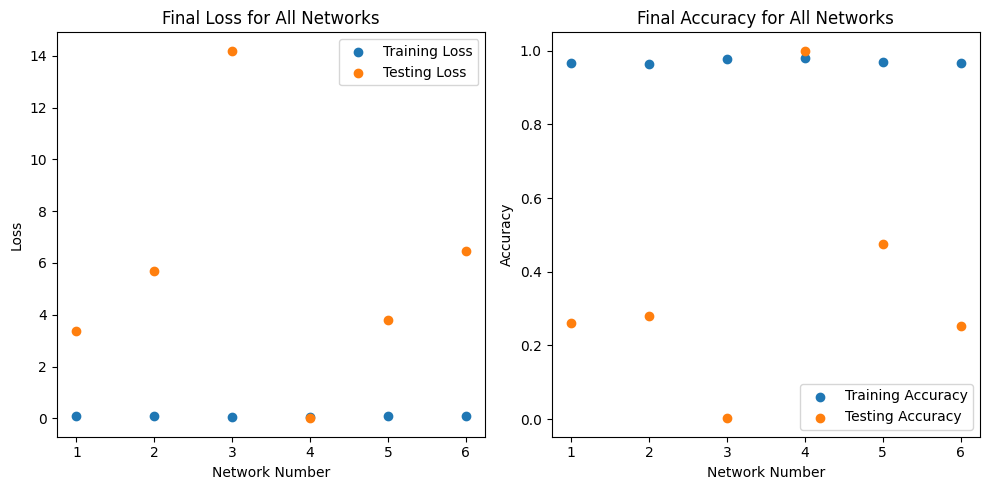

In [6]:
train_loss = loss_train_final
test_loss = loss_test_final
train_acc = acc_train_final
test_acc = acc_test_final
import matplotlib.pyplot as plt


    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the final training and testing loss for all networks
axs[0].scatter(pp[:6], train_loss, label="Training Loss")
axs[0].scatter(pp[:6], test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(pp[:6], train_acc, label="Training Accuracy")
axs[1].scatter(pp[:6], test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

**EX3**

In [ ]:
c_in=1
c_out_stress=3
seq_len=2560
bs=128
more={"depth":4}

for p in pp:
    p=int(p)
    if(p<7):
        print("PP ",p)
        tfms  = [None, [Categorize()]]
        splits=get_train_test_indexes_by_pivot(swell_data[:,0],p) 
        dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)
        dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
        model_stress = InceptionTime(c_in=c_in, c_out=c_out_stress, seq_len=seq_len,**more)
        learn_stress =  ts_learner(dls_stress, model_stress, metrics=accuracy, train_metrics=True)
        record=[]
        for i in range(500):
            learn_stress.fit_one_cycle(1,lr_max=1e-3)
            record.append(learn_stress.final_record.items)
        np.save("./EX3/PP_"+str(p),record)
        learn_stress.save_all(path='./learners_EX3', dls_fname='dls_stress_'+str(p), model_fname='model_stress_'+str(p), learner_fname='learner_stress_'+str(p))
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)

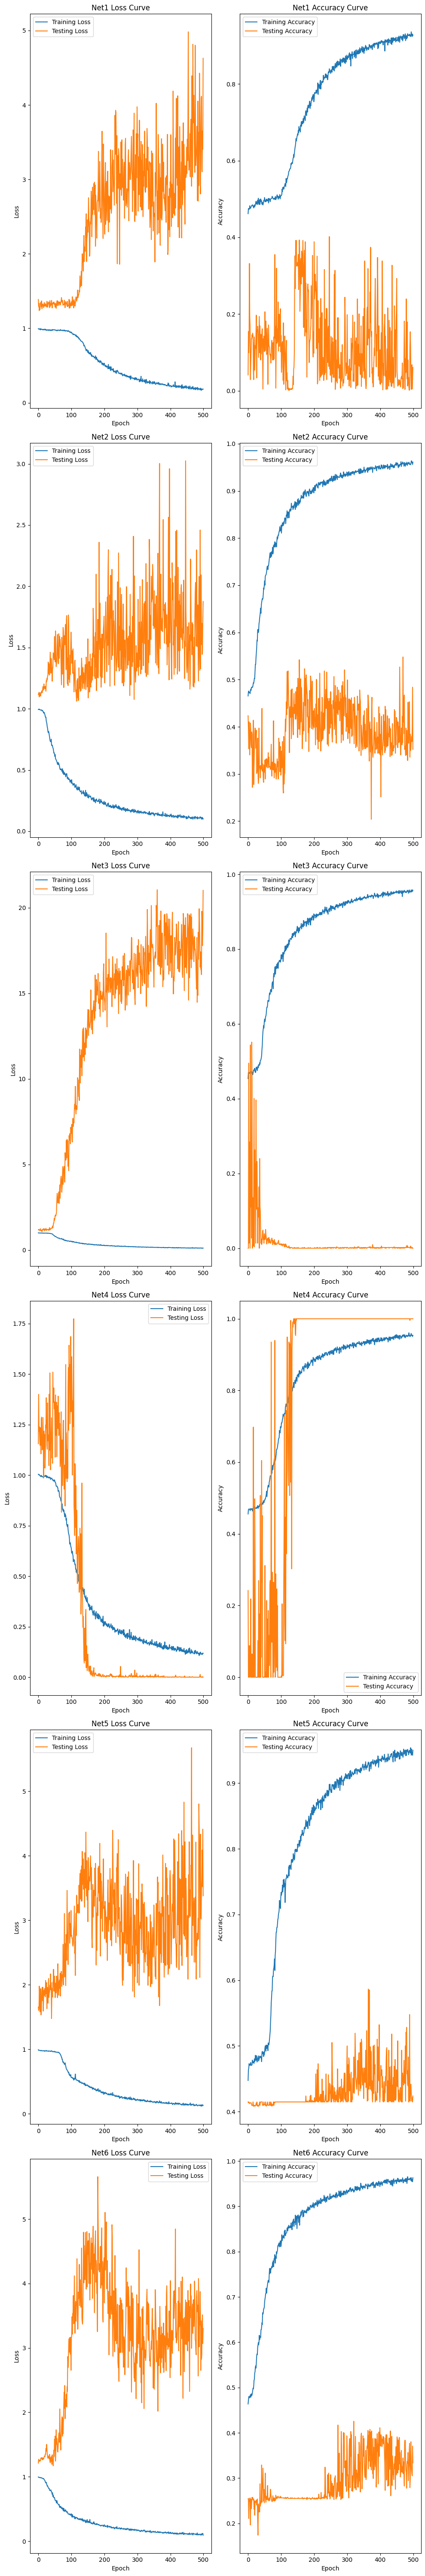

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_train_final=[]
loss_test_final=[]
acc_train_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(6, 2, figsize=(10, 60))

for net in range(1, 7):
    record=np.load("./EX3/PP_"+str(int(pp[net-1]))+".npy") 
    train_loss = record[:,0]
    loss_train_final.append(train_loss[499])
    test_loss = record[:,2]
    loss_test_final.append(test_loss[499])
    train_acc = record[:,1]
    acc_train_final.append(train_acc[499])
    test_acc = record[:,3]
    acc_test_final.append(test_acc[499])
    # Plot the training and testing loss curves for this network
    axs[net-1, 0].plot(train_loss, label="Training Loss")
    axs[net-1, 0].plot(test_loss, label="Testing Loss")
    axs[net-1, 0].set_title(f"Net{int(pp[net-1])} Loss Curve")
    axs[net-1, 0].set_xlabel("Epoch")
    axs[net-1, 0].set_ylabel("Loss")
    axs[net-1, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[net-1, 1].plot(train_acc, label="Training Accuracy")
    axs[net-1, 1].plot(test_acc, label="Testing Accuracy")
    axs[net-1, 1].set_title(f"Net{int(pp[net-1])} Accuracy Curve")
    axs[net-1, 1].set_xlabel("Epoch")
    axs[net-1, 1].set_ylabel("Accuracy")
    axs[net-1, 1].legend()

plt.tight_layout()
plt.show()

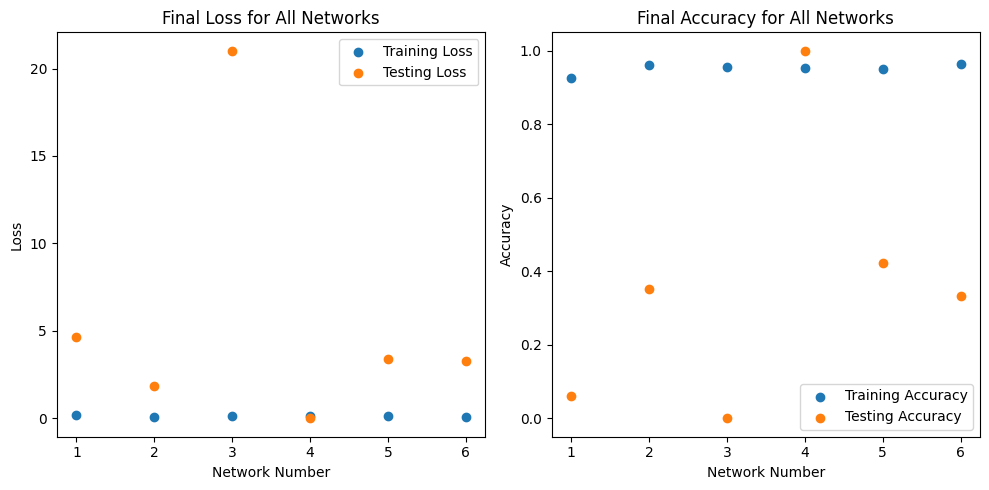

In [8]:
train_loss = loss_train_final
test_loss = loss_test_final
train_acc = acc_train_final
test_acc = acc_test_final
import matplotlib.pyplot as plt


    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the final training and testing loss for all networks
axs[0].scatter(pp[:6], train_loss, label="Training Loss")
axs[0].scatter(pp[:6], test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(pp[:6], train_acc, label="Training Accuracy")
axs[1].scatter(pp[:6], test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

**EX4**

In [ ]:
c_in=1
c_out_stress=3
seq_len=2560
bs=128
more={"ks":20, "depth":4}

for p in pp:
    p=int(p)
    if(1==1):
        print("PP ",p)
        tfms  = [None, [Categorize()]]
        splits=get_train_test_indexes_by_pivot(swell_data[:,0],p) 
        dsets_stress = TSDatasets(X, Y_stress, tfms=tfms, splits=splits, inplace=True)
        dls_stress = TSDataLoaders.from_dsets(dsets_stress.train, dsets_stress.valid, bs=bs, batch_tfms=[TSStandardize()], num_workers=0)
        model_stress = InceptionTime(c_in=c_in, c_out=c_out_stress, seq_len=seq_len, **more)
        learn_stress =  ts_learner(dls_stress, model_stress, metrics=accuracy, train_metrics=True)
        record=[]
        for i in range(500):
            learn_stress.fit_one_cycle(1,lr_max=1e-3)
            record.append(learn_stress.final_record.items)
        np.save("./EX4/PP_"+str(p),record)
        learn_stress.save_all(path='./learners_EX4', dls_fname='dls_stress_'+str(p), model_fname='model_stress_'+str(p), learner_fname='learner_stress_'+str(p))
        torch.cuda.empty_cache()
        torch.cuda.memory_summary(device=None, abbreviated=False)

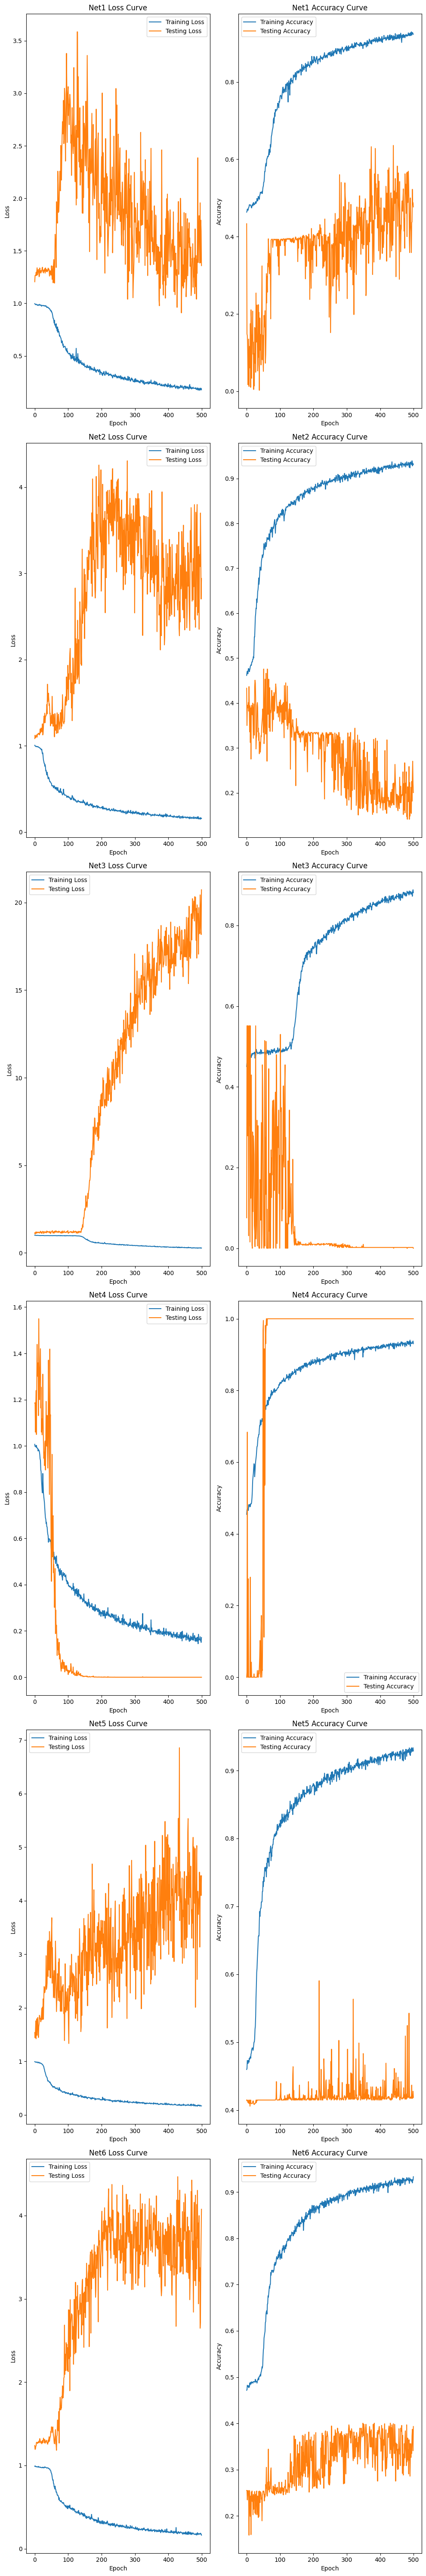

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

loss_train_final=[]
loss_test_final=[]
acc_train_final=[]
acc_test_final=[]


# Assuming you have the training and testing loss/accuracy values for each of the 22 networks stored in a dictionary called "results"
fig, axs = plt.subplots(6, 2, figsize=(10, 60))

for net in range(1, 7):
    record=np.load("./EX4/PP_"+str(int(pp[net-1]))+".npy") 
    train_loss = record[:,0]
    loss_train_final.append(train_loss[499])
    test_loss = record[:,2]
    loss_test_final.append(test_loss[499])
    train_acc = record[:,1]
    acc_train_final.append(train_acc[499])
    test_acc = record[:,3]
    acc_test_final.append(test_acc[499])
    # Plot the training and testing loss curves for this network
    axs[net-1, 0].plot(train_loss, label="Training Loss")
    axs[net-1, 0].plot(test_loss, label="Testing Loss")
    axs[net-1, 0].set_title(f"Net{int(pp[net-1])} Loss Curve")
    axs[net-1, 0].set_xlabel("Epoch")
    axs[net-1, 0].set_ylabel("Loss")
    axs[net-1, 0].legend()
    
    # Plot the training and testing accuracy curves for this network
    axs[net-1, 1].plot(train_acc, label="Training Accuracy")
    axs[net-1, 1].plot(test_acc, label="Testing Accuracy")
    axs[net-1, 1].set_title(f"Net{int(pp[net-1])} Accuracy Curve")
    axs[net-1, 1].set_xlabel("Epoch")
    axs[net-1, 1].set_ylabel("Accuracy")
    axs[net-1, 1].legend()

plt.tight_layout()
plt.show()

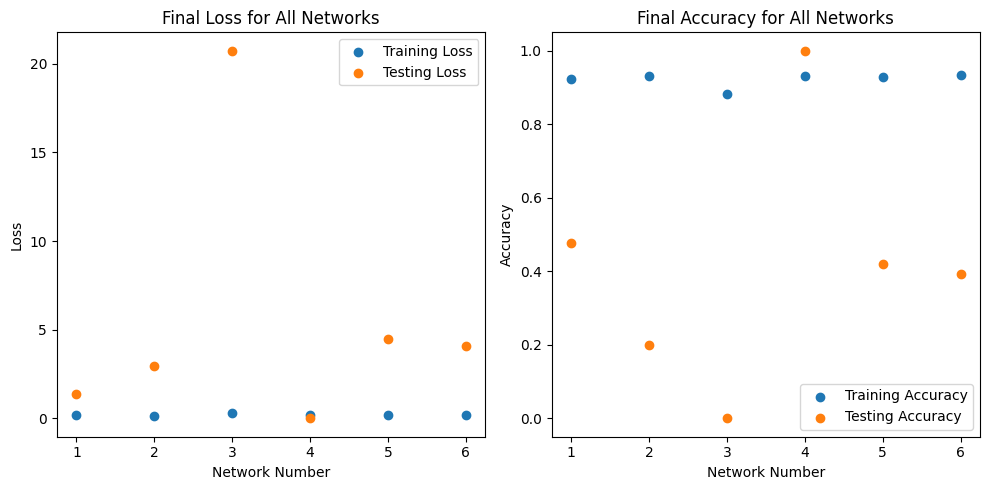

In [10]:
train_loss = loss_train_final
test_loss = loss_test_final
train_acc = acc_train_final
test_acc = acc_test_final
import matplotlib.pyplot as plt


    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the final training and testing loss for all networks
axs[0].scatter(pp[:6], train_loss, label="Training Loss")
axs[0].scatter(pp[:6], test_loss, label="Testing Loss")
axs[0].set_title("Final Loss for All Networks")
axs[0].set_xlabel("Network Number")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot the final training and testing accuracy for all networks
axs[1].scatter(pp[:6], train_acc, label="Training Accuracy")
axs[1].scatter(pp[:6], test_acc, label="Testing Accuracy")
axs[1].set_title("Final Accuracy for All Networks")
axs[1].set_xlabel("Network Number")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()